# Proyecto Final: Lectura de planos CAD

Pruebas realizadas sobre [floor plan](https://drive.google.com/file/d/1Xw-cIvnZdvCMmrIfRs5FkywCXhw-ASOz/view?usp=sharing) el cual puede ser observado con AutoCAD o [ShareCAD](https://sharecad.org/) o [Autodesk Viewer](https://viewer.autodesk.com/)

In [106]:
!python -m pip install ezdxf geopandas

In [107]:
import ezdxf
import geopandas as gpd
import pandas as pd
import fiona; help(fiona.open)
import numpy as np
from shapely.geometry import Polygon, box
import shapely.ops as so
import matplotlib.pyplot as plt

Help on function open in module fiona:

open(fp, mode='r', driver=None, schema=None, crs=None, encoding=None, layer=None, vfs=None, enabled_drivers=None, crs_wkt=None, **kwargs)
    Open a collection for read, append, or write
    
    In write mode, a driver name such as "ESRI Shapefile" or "GPX" (see
    OGR docs or ``ogr2ogr --help`` on the command line) and a schema
    mapping such as:
    
      {'geometry': 'Point',
       'properties': [('class', 'int'), ('label', 'str'),
                      ('value', 'float')]}
    
    must be provided. If a particular ordering of properties ("fields"
    in GIS parlance) in the written file is desired, a list of (key,
    value) pairs as above or an ordered dict is required. If no ordering
    is needed, a standard dict will suffice.
    
    A coordinate reference system for collections in write mode can be
    defined by the ``crs`` parameter. It takes Proj4 style mappings like
    
      {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'W

## Definicion de clases custom

In [108]:
class Square(Polygon):
  def __init__(self, side:float, start_x: float=0, start_y: float=0):
    end_x = start_x+side
    end_y = start_y+side
    return super().__init__([(start_x, start_y), (end_x, start_y), (end_x, end_y), (start_x, end_y)])

## Lectura del plano en formato .dxf

In [109]:
doc = ezdxf.readfile("/content/drive/MyDrive/Proyecto final/Floor plan.dxf")
clean_doc = ezdxf.new('R2010')
msp = doc.modelspace()
clean_msp = clean_doc.modelspace()

for e in msp.query("LINE [layer=='xref-Bishop-Overland-08$0$A-WALL']"):
    clean_msp.add_line(start=e.dxf.start, end=e.dxf.end)

clean_doc.saveas("/content/drive/MyDrive/Proyecto final/Floor plan clean.dxf")

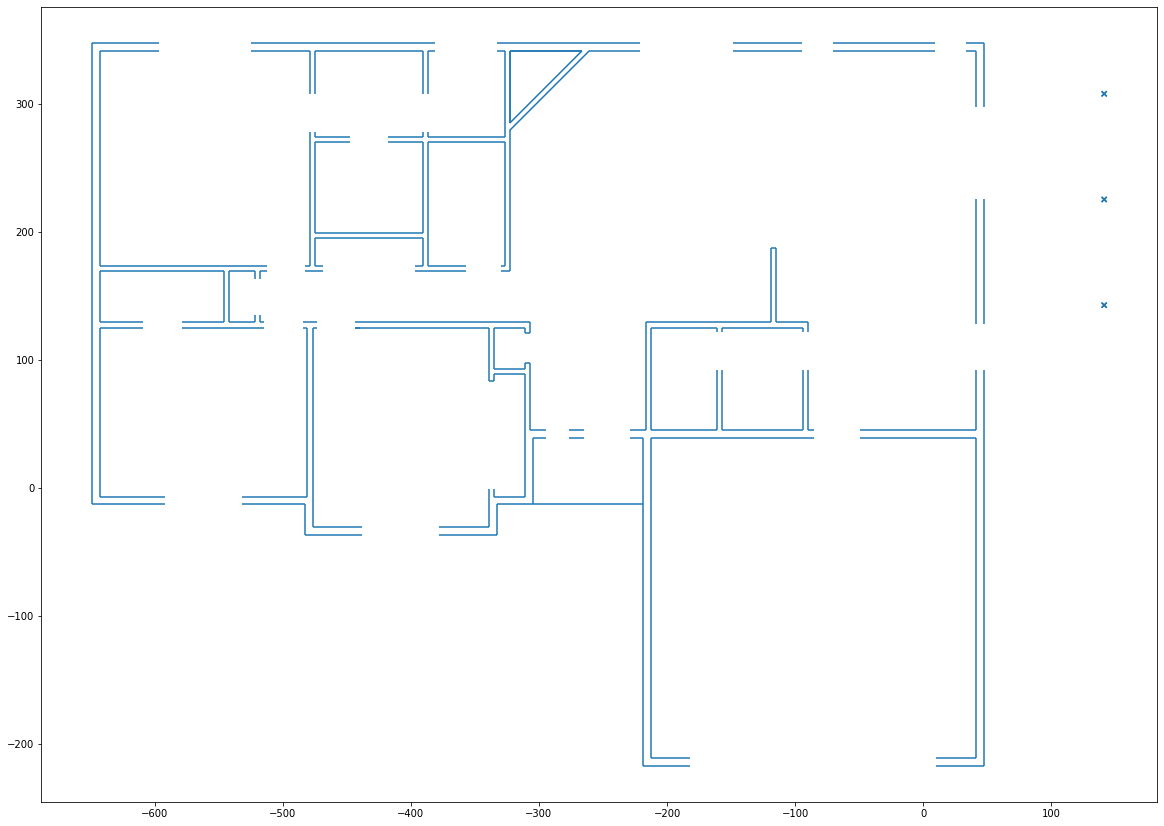

In [110]:
layout = gpd.read_file("/content/drive/MyDrive/Proyecto final/Floor plan clean.dxf")
layout.plot(figsize=(20,20))

## Conversion de plano a grilla de ocupacion
Una vez levantado el plano de CAD, procedemos a crear una grilla de ocupacion, definida por cuadrados de lado `square_size`, los cuales se buscaran superponer al plano obtenido.
Asi, los poligonos que coincidan con las lineas del plano seran aquellos que formaran parte de los **bloques ocupados** en la grilla de ocupacion.

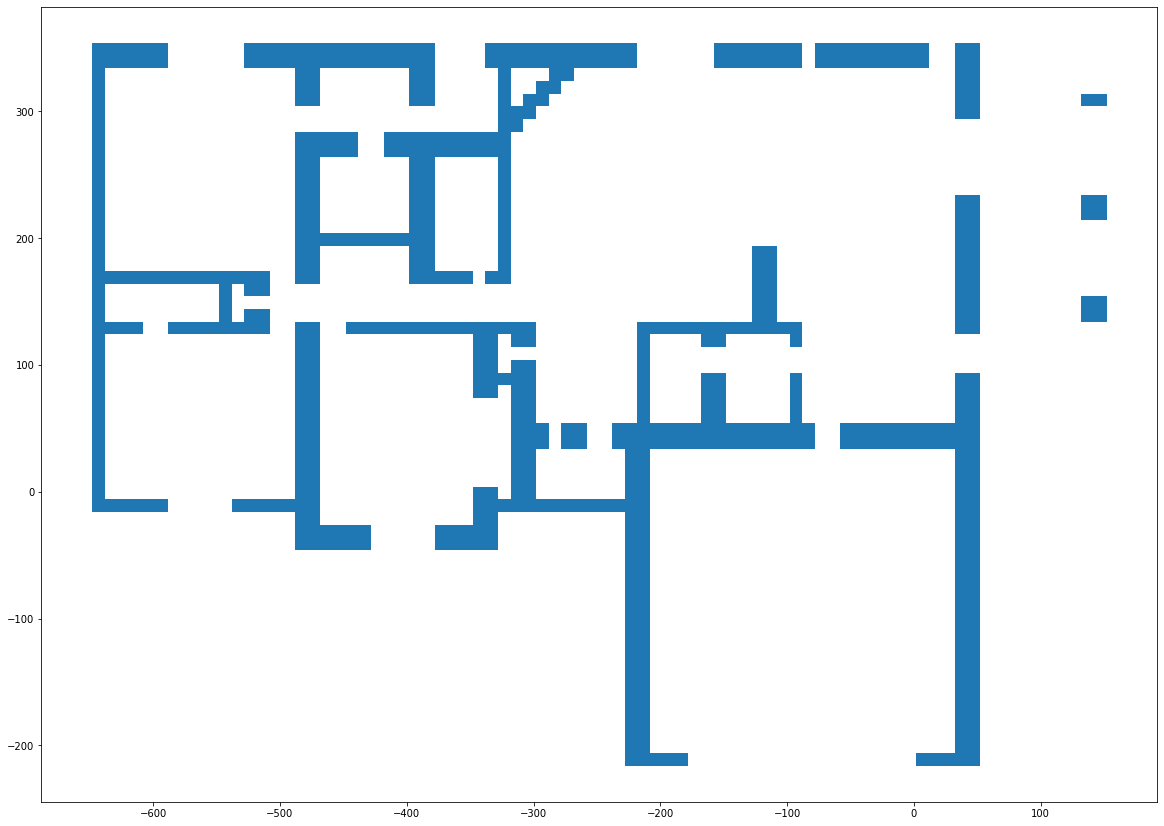

In [118]:
clean_layout = layout['geometry']
xmin, ymin, xmax, ymax = clean_layout.total_bounds

polygons_list = []
square_size = 10
for xstart in range(int(xmin), int(xmax), square_size):
  for ystart in range(int(ymin), int(ymax), square_size):
    polygons_list.append(Square(square_size, xstart, ystart))


shape = gpd.GeoDataFrame(geometry=polygons_list)
shape["intersects"]= shape.intersects(clean_layout.unary_union)
occupied_blocks = shape.query("intersects == True")
occupied_blocks.plot(figsize=(20,20))

In [122]:
def get_center(item):
  xmin, ymin, xmax, ymax = item["geometry"].bounds
  return pd.Series([(xmax+xmin)/2, (ymax+ymin)/2, int(item["intersects"])], index=['axis_x', 'axis_y', 'occuped'])
occupancy_grid = shape.apply(get_center, axis=1, result_type='expand')

,axis_x,axis_y,occuped
0,-643.0,-211.0,0.0
1,-643.0,-201.0,0.0
2,-643.0,-191.0,0.0
3,-643.0,-181.0,0.0
4,-643.0,-171.0,0.0
...,...,...,...
4555,147.0,309.0,1.0
4556,147.0,319.0,0.0
4557,147.0,329.0,0.0
4558,147.0,339.0,0.0
